In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine 

### Конфигурация для подключения к базе данных `data-analyst-advanced-sql`
Эта база данных содержит схему `stackoverflow`, с которой будем работать в проекте

In [2]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [3]:
engine = create_engine(connection_string) 

Пример запроса к базе данных

`sample_df` является pandas-датафреймом.

In [4]:
query = '''
SELECT *
FROM stackoverflow.users
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine) 

In [5]:
sample_df

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700
5,8,2008-07-31 21:33:24,Eggs McLaren,2018-04-09 02:04:56,None,942,6372
6,9,2008-07-31 21:35:27,Kevin Dente,2018-08-30 18:18:03,"Oakland, CA",14337,4949
7,11,2008-08-01 00:59:11,Anonymous User,2008-08-01 00:59:11,None,1890,2123
8,13,2008-08-01 04:18:05,Chris Jester-Young,2018-08-30 02:47:23,"Raleigh, NC, United States",177138,35414
9,17,2008-08-01 12:02:22,Nick Berardi,2018-01-22 01:35:38,"Issaquah, WA",44443,4786


# Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [6]:
# напишите запрос
query = '''
SELECT DISTINCT 
       DATE_TRUNC('month', creation_date) AS dt,
       SUM(views_count) OVER (PARTITION BY DATE_TRUNC('month', creation_date)) AS total_views
FROM stackoverflow.posts
ORDER BY total_views DESC;
'''

# выполните запрос
month_views = pd.read_sql_query(query, con=engine)
month_views

,dt,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


Проанализируйте итоговую таблицу. Отличаются ли данные за разные месяцы? С чем могут быть связаны отличия?

Количество постов было минимальным с июле, низким в августе, в сентябре количество постов резко выросло и дальше плавно снижалось до конца года. Можно предположить что это обусловлено сезонными колебаниями. Летом большое количество людей в отпусках, к новогодним праздникам работоспособность так же снижается.

# Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

| display_name | count |
| ------------ | ----- |
| 1800 INFORMATION | 1 |
| Adam Bellaire | 1 |
| Adam Davis | 1 |
| ... | ... |

In [7]:
# напишите запрос
query = '''
SELECT u.display_name,
       COUNT(DISTINCT u.id)
FROM stackoverflow.users AS u
JOIN stackoverflow.posts AS p ON u.id = p.user_id
JOIN stackoverflow.post_types AS pt ON p.post_type_id = pt.id
WHERE pt.type = 'Answer'
      AND DATE_TRUNC('day', p.creation_date) >= DATE_TRUNC('day', u.creation_date)
      AND DATE_TRUNC('day', p.creation_date) <= DATE_TRUNC('day', u.creation_date) + INTERVAL '1 month'
GROUP BY u.display_name
HAVING COUNT(*) > 100;
'''

# выполните запрос
names = pd.read_sql_query(query, con=engine)
names

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,8
...,...,...
74,lomaxx,1
75,mattlant,1
76,paxdiablo,1
77,tvanfosson,1


In [8]:
names.sort_values(by='count', ascending=False).head(20)

,display_name,count
45,Matt,29
10,Chris,29
14,Dan,21
64,Tom,19
41,Mark,17
50,Nick,16
33,Josh,16
7,Brian,15
56,Rob,15
21,Greg,12


Какие аномалии наблюдаются в данных? О чём они говорят?

Количесто id пользователей с одним именем,говорит о том что разные пользователи могут иметь одинаковые имена.   

# Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 18294 |
| ... | ... |

In [9]:
# напишите запрос
query = '''
WITH
id AS (SELECT DISTINCT p.user_id
       FROM stackoverflow.posts AS p 
       LEFT JOIN stackoverflow.users AS u ON u.id = p.user_id
       WHERE DATE_TRUNC('month',u.creation_date) = '2008-09-01' 
             AND DATE_TRUNC('month',p.creation_date) = '2008-12-01')
             
SELECT DATE_TRUNC('month',p.creation_date) AS month,
       COUNT(p.id) 
FROM stackoverflow.posts AS p
JOIN id ON id.user_id = p.user_id
GROUP BY DATE_TRUNC('month',p.creation_date)
ORDER BY month DESC;
'''

# выполните запрос
posts_count = pd.read_sql_query(query, con=engine)
posts_count

,month,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


Изучите данные: есть ли в них аномалии? Предположите, почему могли появиться аномальные значения.

По резульатам таблицы можно увидеть, что пользователи зарегестрированые в сентябре 2008 каким то образом писали посты в августе 2008, чего в реальности быть не может. Верояна техническая ошибка.

# Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [10]:
# напишите запрос
query = '''
SELECT user_id,
       creation_date,
       views_count,
       SUM(views_count) OVER (PARTITION BY user_id ORDER BY creation_date)  AS cumulative_count
FROM stackoverflow.posts;
'''

# выполните запрос
posts = pd.read_sql_query(query, con=engine)
posts

,user_id,creation_date,views_count,cumulative_count
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


# Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.777778  |
| 234     | 5.208333  |
| ...     | ... |

In [11]:
# напишите запрос
query = ''' 
WITH 
id AS (SELECT user_id,
             COUNT(id) AS post_count
      FROM stackoverflow.posts
      WHERE DATE_TRUNC('month',creation_date) = '2008-08-01'
      GROUP BY user_id
      HAVING COUNT(id) > 120),
      
cp AS (SELECT p.user_id,
              DATE_TRUNC('day',p.creation_date) AS creation_date,
              COUNT(p.id)  AS day_count
       FROM stackoverflow.posts AS p
       JOIN id ON id.user_id = p.user_id
       WHERE DATE_TRUNC('month',p.creation_date) = '2008-08-01'
       GROUP BY p.user_id,DATE_TRUNC('day',p.creation_date))
       
SELECT user_id,
       AVG(day_count) AS daily_avg 
FROM cp
GROUP BY user_id
ORDER BY AVG(day_count);
'''

# выполните запрос
avg_posts = pd.read_sql_query(query, con=engine)
avg_posts

,user_id,daily_avg
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

| result |
| -----  |
| <целое число> |

In [12]:
# напишите запрос
query = '''
WITH days AS (SELECT user_id,
                    COUNT(DISTINCT creation_date :: date) AS cnt
                     FROM stackoverflow.posts
                     WHERE creation_date :: date BETWEEN '2008-12-01' AND '2008-12-07'
                     GROUP BY user_id)
SELECT ROUND (AVG(cnt))::varchar AS result
FROM days;
'''

# выполните запрос
days  = pd.read_sql_query(query, con=engine)
days

,result
0,2


Проанализируйте итоговую таблицу — какие выводы можно сделать?

 В среднем, каждый пользователь, который выкладывал посты, провел на платформе 2 дня в период с 1 по 7 декабря 2008 года. 

# Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | None |
| 1       | 2008-07-31 23:55:38 | None |
| 1       | 2008-07-31 23:56:41 | July |
| 1       | 2008-08-04 02:45:08 | July |
| 1       | 2008-08-04 04:31:03 | July |
| 1       | 2008-08-04 08:04:42 | August |
| ... | ... | ... |

In [13]:
# напишите запрос
query = '''
SELECT user_id,
       creation_date,
       CASE 
           WHEN  DATE_TRUNC('month',LAG(creation_date) 
                 OVER (PARTITION BY user_id ORDER BY creation_date)) = '2008-01-01' THEN 'January'
           WHEN  DATE_TRUNC('month',LAG(creation_date) 
                 OVER (PARTITION BY user_id ORDER BY creation_date)) = '2008-02-01' THEN 'February'
           WHEN  DATE_TRUNC('month',LAG(creation_date) 
                 OVER (PARTITION BY user_id ORDER BY creation_date)) = '2008-03-01' THEN 'March'
           WHEN  DATE_TRUNC('month',LAG(creation_date) 
                 OVER (PARTITION BY user_id ORDER BY creation_date)) = '2008-04-01' THEN 'April'
           WHEN  DATE_TRUNC('month',LAG(creation_date) 
                 OVER (PARTITION BY user_id ORDER BY creation_date)) = '2008-05-01' THEN 'May'
           WHEN  DATE_TRUNC('month',LAG(creation_date) 
                 OVER (PARTITION BY user_id ORDER BY creation_date)) = '2008-06-01' THEN 'June'
           WHEN  DATE_TRUNC('month',LAG(creation_date) 
                 OVER (PARTITION BY user_id ORDER BY creation_date)) = '2008-07-01' THEN 'July'
           WHEN  DATE_TRUNC('month',LAG(creation_date) 
                 OVER (PARTITION BY user_id ORDER BY creation_date)) = '2008-08-01' THEN 'August'
           WHEN  DATE_TRUNC('month',LAG(creation_date) 
                 OVER (PARTITION BY user_id ORDER BY creation_date)) = '2008-09-01' THEN 'September'
           WHEN  DATE_TRUNC('month',LAG(creation_date) 
                 OVER (PARTITION BY user_id ORDER BY creation_date)) = '2008-10-01' THEN 'October'
           WHEN  DATE_TRUNC('month',LAG(creation_date) 
                 OVER (PARTITION BY user_id ORDER BY creation_date)) = '2008-11-01' THEN 'November'
           WHEN  DATE_TRUNC('month',LAG(creation_date) 
                 OVER (PARTITION BY user_id ORDER BY creation_date)) = '2008-12-01' THEN 'December' 
           ELSE NULL
       END AS second_last_month
FROM stackoverflow.posts
ORDER BY user_id, creation_date;
'''

# выполните запрос
second_last_month = pd.read_sql_query(query, con=engine)
second_last_month

,user_id,creation_date,second_last_month
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,July
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,August
...,...,...,...
243791,5696608,2008-12-23 16:00:37,December
243792,5696608,2008-12-23 17:35:09,December
243793,5696608,2008-12-24 01:02:48,December
243794,5696608,2008-12-30 14:34:45,December


# Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

In [14]:
# напишите запрос
query = '''
WITH 
first_post AS (SELECT DISTINCT user_id,
                      FIRST_VALUE(DATE_TRUNC('month', creation_date)) 
                      OVER(PARTITION BY user_id ORDER BY creation_date) AS cohort_dt
               FROM stackoverflow.posts),
 
profile AS (SELECT user_id,
                   cohort_dt,
                   COUNT(*) OVER(PARTITION BY cohort_dt) AS cohort_users_cnt
            FROM first_post),
 
sessions AS (SELECT user_id,
                    DATE_TRUNC('month', creation_date) AS session_date
                    FROM stackoverflow.posts
                    GROUP BY 1, 2)
 
 
SELECT p.cohort_dt,
       session_date,
       COUNT(p.user_id) AS users_cnt,
       cohort_users_cnt,
       ROUND(COUNT(p.user_id) * 100.0 / cohort_users_cnt, 2) AS retention_rate
FROM profile p
JOIN sessions s ON p.user_id = s.user_id
GROUP BY 1,
         2,
         4
ORDER BY 1, 2;
'''
 
# выполните запрос
rr = pd.read_sql_query(query, con=engine) 
rr

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


Постройте тепловую карту Retention Rate. Какие аномалии или другие необычные явления удалось выявить? Сформулируйте гипотезы о возможных причинах.

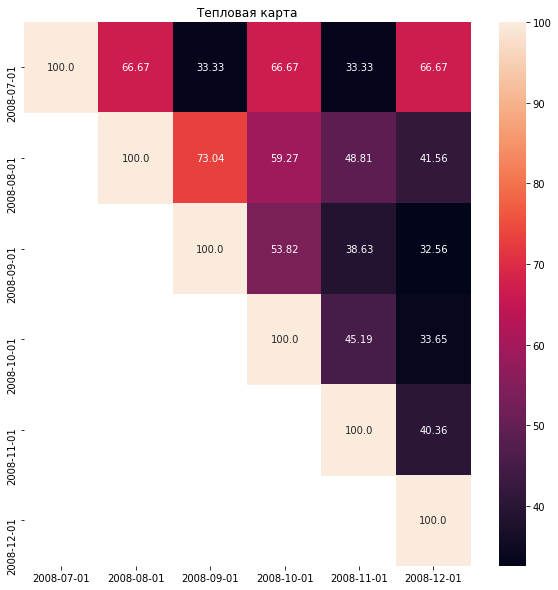

In [15]:
table = rr.pivot('cohort_dt', 'session_date', 'retention_rate')
table.index = [str(x)[0:10] for x in table.index]
table.columns = [str(x)[0:10] for x in table.columns]

# строим хитмэп
plt.figure(figsize=(10, 10))
sns.heatmap(table, 
            annot=True,
            fmt='') 
plt.title('Тепловая карта') 
plt.show() # постройте тепловую карту Retention Rate

Кажется, что июльские пользователи очень странно удерживаются. Но размер когорты очень маленький ( 3 человека) то эти данные не стоит брать в анализ
Удержание в когорте каждого следуюшего месяца начиная с августа становится все хуже. Стоит внимательнее посмотреть каналы привлечения пользвателей, возможно пересмотреть стартегии по привлечению.

# Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | Nan |
| 10 | 63102 | -10.33 |
| ... | ... | ... |

In [16]:
# напишите запрос
query = '''
WITH 
post AS (SELECT DATE_TRUNC('month', creation_date) AS month,
                COUNT(id) AS count_posts
         FROM stackoverflow.posts
         WHERE DATE_TRUNC('day',creation_date)>='2008-09-01' AND DATE_TRUNC('day',creation_date)<='2008-12-31'
         GROUP BY month)
         
SELECT *,
     ROUND((count_posts :: numeric/ LAG(count_posts) OVER() - 1)*100,2)
FROM post;
'''

# выполните запрос
posts = pd.read_sql_query(query, con=engine) 
posts

,month,count_posts,round
0,2008-09-01,70371,NaN
1,2008-10-01,63102,-10.33
2,2008-11-01,46975,-25.56
3,2008-12-01,44592,-5.07


Постройте круговую диаграмму с количеством постов по месяцам.

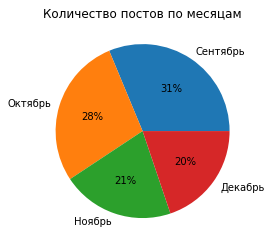

In [17]:
posts['month'] = ['Сентябрь', 'Октябрь', 'Ноябрь' ,'Декабрь']
plt.pie(posts['count_posts'], labels = posts['month'],autopct='%.0f%%')
plt.title('Количество постов по месяцам')
plt.show() # постройте круговую диаграмму с количеством постов по месяцам

# Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [18]:
# напишите запрос
query = '''
WITH
tu AS (SELECT user_id,
              COUNT(id)
       FROM stackoverflow.posts
       GROUP BY user_id
       ORDER BY COUNT(id) DESC
       LIMIT 1),

tup AS (SELECT p.user_id,
               p.creation_date,
               EXTRACT('week' FROM p.creation_date) AS week_n
        FROM stackoverflow.posts AS p
        JOIN tu ON tu.user_id = p.user_id
        WHERE DATE_TRUNC('month', p.creation_date) = '2008-10-01')
        
SELECT DISTINCT week_n,
       MAX(creation_date) OVER (PARTITION BY week_n) AS creation_dt
FROM tup
ORDER BY week_n;
'''

# выполните запрос
top_user = pd.read_sql_query(query, con=engine)
top_user

,week_n,creation_dt
0,40.0,2008-10-05 09:00:58
1,41.0,2008-10-12 21:22:23
2,42.0,2008-10-19 06:49:30
3,43.0,2008-10-26 21:44:36
4,44.0,2008-10-31 22:16:01
